# HOBYS dr21_s2

In [16]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/HOBYS/dr21/'
name = 'dr21_s2'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [7]:
figfile = path + 'dr21_coldens_cf_r500_medsmo3_rebin_rot.fits'

In [8]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

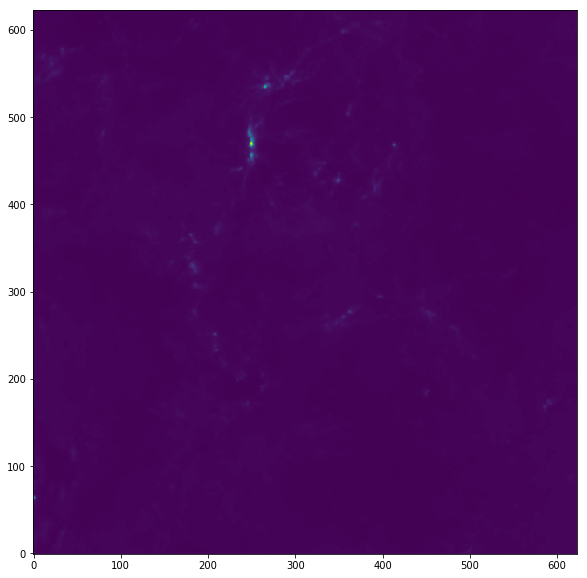

In [9]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to  4.402e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.115e+22 [aplpy.core]


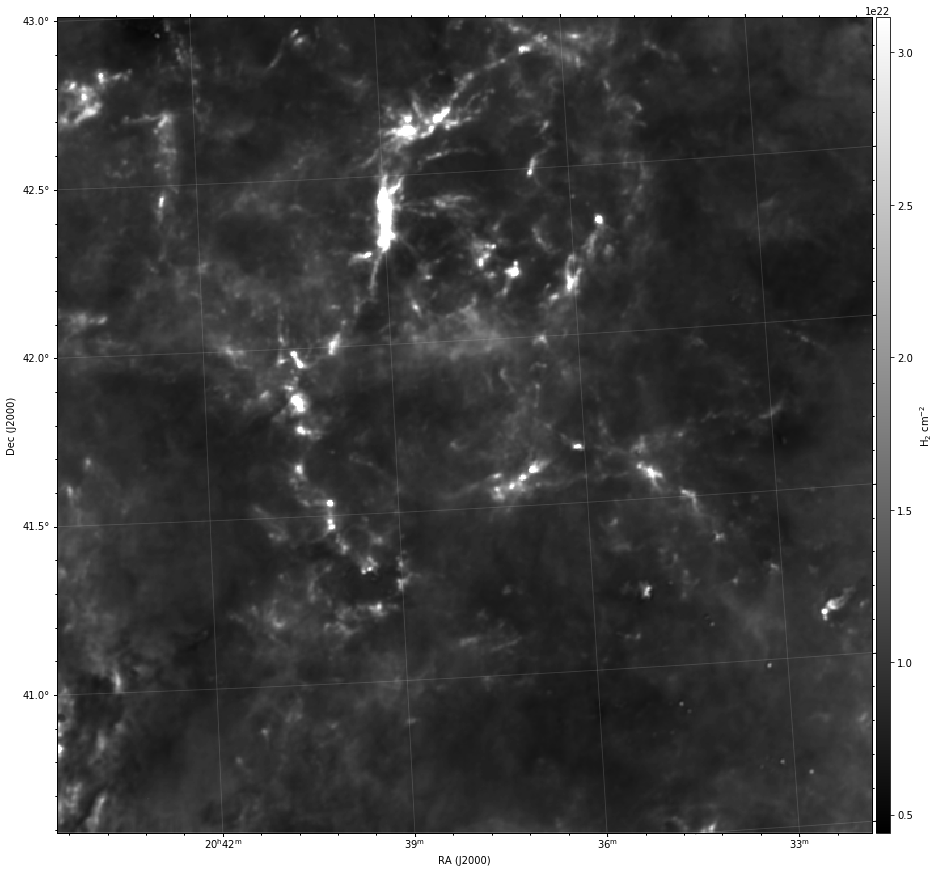

In [11]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'dr21_coldens_cf_r500_medsmo3_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [12]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

In [69]:
#Cut the map
input = path + 'dr21_coldens_cf_r500_medsmo3_rebin_rot.fits'
output = path + name + '_coldens_cf_r500_medsmo3_rebin_rot_cut.fits'
coords = np.array([310,143,604,345])
subfits(input,output,coords)

Dimensions 295 203


In [70]:
#Read map
HDU = fits.open(path + name + '_coldens_cf_r500_medsmo3_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to  4.847e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.817e+22 [aplpy.core]


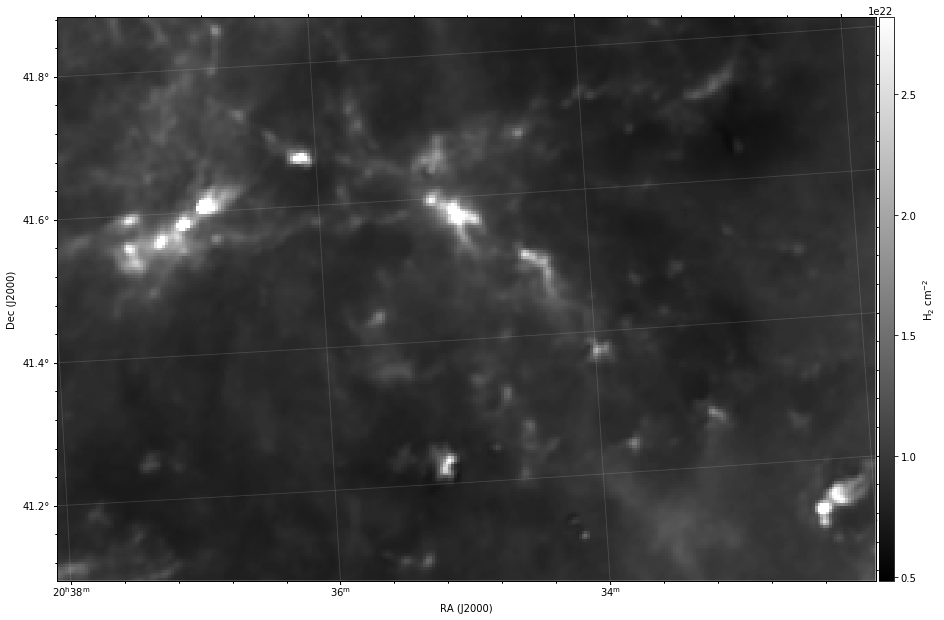

In [71]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [72]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((400,400))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [73]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

400 400


Text(0.5, 1.0, 'Beam power spectrum')

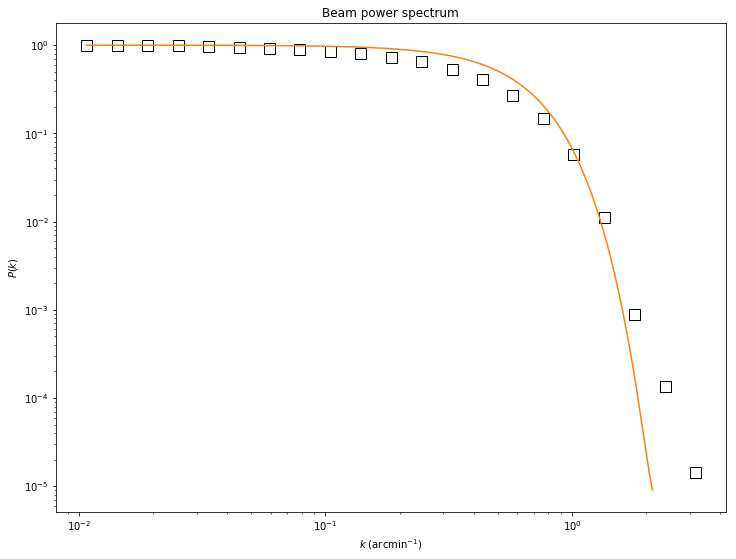

In [74]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  3.31601e+42 -1.43423 4.57301e+41
Gaussian wavelet
A, Gamma, P0 =  3.6903289275393007e+40 -2.99560297109336 0.0


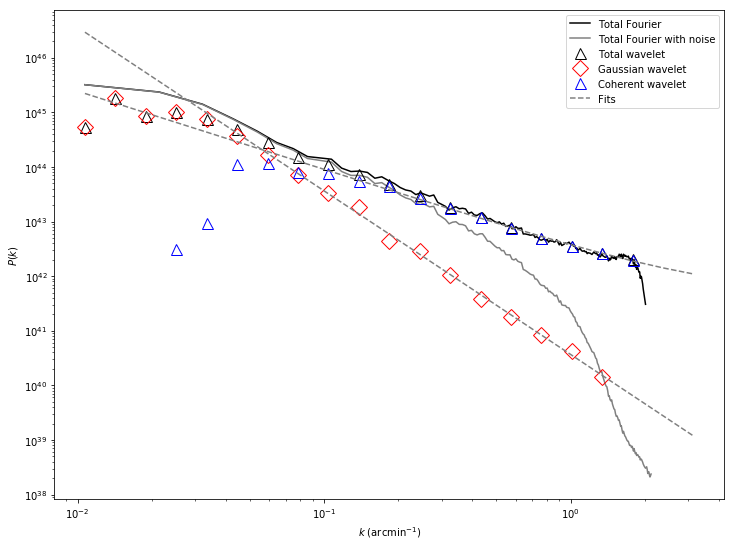

In [75]:
Noise=spec_k[-1]

#Power spectra fits
A_gauss, cov = np.polyfit(np.log(wav_k[7:18]), np.log((S1a[2,7:18]-Noise)/(BS1an[7:18])),deg=1,cov=True)
fit_gauss = np.exp(A_gauss[1])*wav_k**A_gauss[0]
A_cohe, gamma_cohe, P0_cohe = 33.1601e+41,     -1.43423, 4.57301e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', np.exp(A_gauss[1]), A_gauss[0], 0.)


plt.figure(figsize(12,9))
plt.plot(tab_k[:-10], (spec_k[:-10]-Noise)/spec_beamn2[:-10], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

plt.savefig(path + name + '_coldens_cf_r500_medsmo3_power_spec.png', dpi=500)

In [76]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

fits.writeto(path + name + '_coldens_cf_r500_medsmo3_reconst_filaments.fits', filaments, header, overwrite=True)
fits.writeto(path + name + '_coldens_cf_r500_medsmo3_reconst_scale_free.fits', scale_free, header, overwrite=True)

INFO: Auto-setting vmin to -4.169e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.368e+22 [aplpy.core]
INFO: Auto-setting vmin to -3.355e+21 [aplpy.core]
INFO: Auto-setting vmax to  4.756e+21 [aplpy.core]


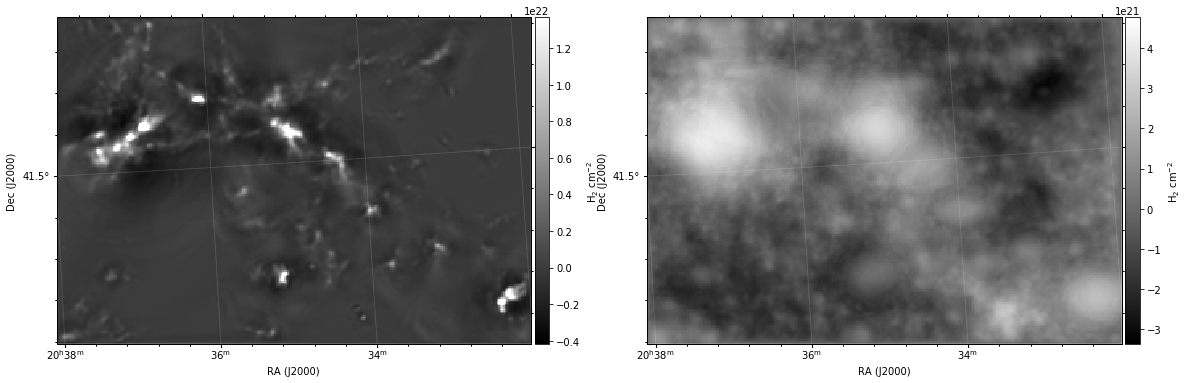

In [77]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_reconst_filaments.fits',figure=fig_all, subplot=(1,3,1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

fig = aplpy.FITSFigure(path + name + '_coldens_cf_r500_medsmo3_reconst_scale_free.fits',figure=fig_all, subplot=(1,3,2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')